In [6]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as ptch

In [69]:
# axes = a and b
a_min_star = -4
a_max_star = 5
a_len_star = np.abs(a_max_star - a_min_star)

b_min_star = -4
b_max_star = 8
b_len_star = np.abs(b_max_star - b_min_star)

alpha = a_len_star / b_len_star

def f(a, b):
    return a_min_star <= a <= a_max_star and b_min_star <= b <= b_max_star

assert f(2, 4) == True
assert np.isclose(alpha, 3/4)

In [117]:
m = 200
S = np.random.uniform(0, 10, (m, 2))
S = [(p[0], p[1], f(p[0], p[1])) for p in S]
S = np.array(S, dtype=object)
S.shape, S[:5]

((200, 3),
 array([[6.68840366742924, 9.759057923556403, False],
        [4.158002588898802, 7.586499751374905, True],
        [4.897469931392624, 3.570836601716204, True],
        [0.5835415172133807, 4.45481694649735, True],
        [1.221058781019041, 8.576487095099216, False]], dtype=object))

In [177]:
# solve for 'erm', 'alpha', 'naive'
def learn_h(alpha, S, solve_for='erm'):
    # 1. compute minimal rectangle for positive examples
    S_positive = S[S[:, 2] == True]
    a_min = np.min(S_positive[:, 0])
    a_max = np.max(S_positive[:, 0])
    b_min = np.min(S_positive[:, 1])
    b_max = np.max(S_positive[:, 1])
    a_len = np.abs(a_max - a_min)
    b_len = np.abs(b_max - b_min)
    
    # 2. compute minimal rectangle ratio and exit if good
    beta = a_len / b_len
    
    if np.isclose(alpha, beta) or solve_for == 'naive':
        return a_min, b_min, a_len, b_len, \
            lambda a,b: a_min <= a <= a_min + a_len and b_min <= b <= b_min + b_len
    
    # 3. expand the rectangle to match the ratio
    a_prime_len = a_len
    b_prime_len = b_len
    
    if beta < alpha:
        a_prime_len += alpha * b_len - a_len
    else:
        b_prime_len += a_len / alpha - b_len
        
    assert np.isclose(a_prime_len / b_prime_len, alpha)
    
    if solve_for == 'alpha':
        return a_min, b_min, a_prime_len, b_prime_len, \
            lambda a,b: a_min <= a <= a_min + a_prime_len and b_min <= b <= b_min + b_prime_len
    
    # 4. find the closest points we misclassify as being positive
    a_i_min = np.inf
    b_i_min = np.inf
    
    for (a_i, b_i, y_i) in S:
        if y_i == True:
            continue
            
        if a_min <= a_i and a_i <= a_min + a_prime_len and b_min <= b_i and b_i <= b_min + b_prime_len:
            a_i_min = min(a_i_min, a_i)
            b_i_min = min(b_i_min, b_i)
    
    # 5. find the correct displacement of the rectangle
    a_prime_max = a_min + a_prime_len
    b_prime_max = b_min + b_prime_len
    
    delta = 1e-5
    if beta < alpha and a_i_min != np.inf:
        a_prime_max = a_i_min - delta
    elif b_i_min != np.inf:
        b_prime_max = b_i_min - delta
    
    # 6. compute the final length
    a_second_len = a_prime_max - a_min
    b_second_len = b_prime_max - b_min
    
    return a_min, b_min, a_second_len, b_second_len, \
        lambda a,b: a_min <= a <= a_min + a_second_len and b_min <= b <= b_min + b_second_len

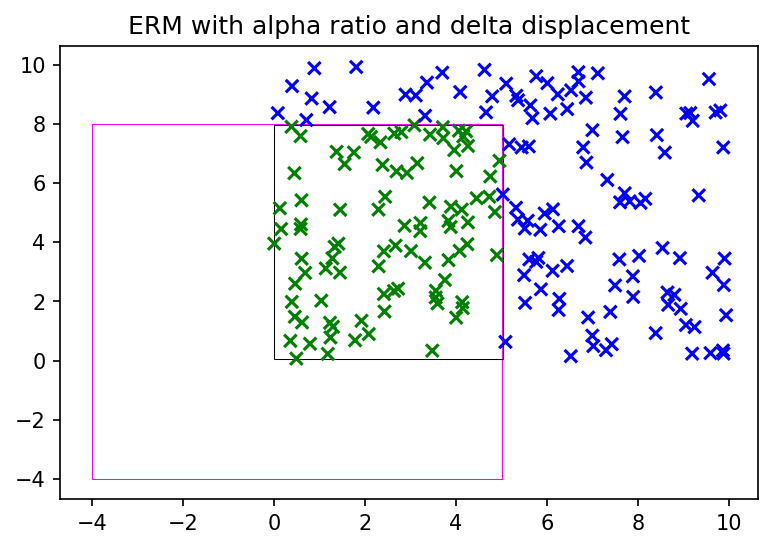

In [184]:
a_min, b_min, a_len, b_len, h = learn_h(alpha, S, 'erm')
y_wrong = [(p[0], p[1], 'red') for p in S if p[2] != h(p[0], p[1])]
y_wrong = np.array(y_wrong, dtype=object)

R_S = ptch.Rectangle((a_min, b_min), a_len, b_len, edgecolor='black', facecolor='none', linewidth=0.5)
R_star = ptch.Rectangle((a_min_star, b_min_star), a_len_star, b_len_star, edgecolor='magenta', facecolor='none', linewidth=0.5)

fig, ax = plt.subplots(dpi=150)
ax.set_title('ERM with alpha ratio and delta displacement')
ax.add_patch(R_star)
ax.add_patch(R_S)
ax.scatter(S[:, 0], S[:, 1], c=['green' if y else 'blue' for y in S[:, 2]], marker='x')
if len(y_wrong):
    ax.scatter(y_wrong[:, 0], y_wrong[:, 1], c=y_wrong[:, 2], marker='x')


plt.show()